# 1단계 정보통신망이용촉진 및 정보보호 등에 관련한 법률(텍스트) clustering

## 1-1. 정보통신망이용촉진 및 정보보호 등 관련 법률 엑셀 파일을 Pandas를 통해 해당 csv 파일로부터 문장 단위로 데이터 추출한다



In [ ]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

path='./판례목록.csv'
df=pd.read_csv(path)
df2=df.dropna(axis=0)
law_list=df2.values.tolist()
law_list

In [ ]:
init_data=[]    #불러온 csv파일에서 활용할 자료들, 법률 이름과 판시사항만을 담은 init_data 리스트 생성 
for i in range(len(law_list)):
  temp=law_list[i][1]+law_list[i][6]
  init_data.append(temp)

In [ ]:
init_data

In [ ]:

!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)


## 1-2. Konlpy를 사용하여 문장을 단어로 tokenize한다


In [ ]:
from konlpy.tag import Mecab

token_title=[]
token_example=[]
token=[]

def tokenize_sentence_title(text):
    mecab=Mecab()
    for i in range(len(text)):
      token_title.append(mecab.nouns(text[i][1]))

def tokenize_sentence_example(text):
    mecab=Mecab()
    for i in range(len(text)):
      token_example.append(mecab.nouns(text[i][6]))

tokenize_sentence_title(law_list)
tokenize_sentence_example(law_list)


In [ ]:
for i in range(len(law_list)):
    temp=token_title[i]+token_example[i]
    token.append(temp)

token

## 1-3. Gensim을 사용하여 word embedding한다

In [ ]:
from gensim.models import Word2Vec as w2v
model = w2v(token, size=100, window=2, min_count=50, iter=20, sg=1) # 포스태깅된 token들, 단어들을 각각 100차원의 벡터로 바꾸기 위해 word2vec 모듈을 사용하여 word embedding함
                                                                    # 클러스터링과 같은 연산을 위해서는 각 단어들을 수학적인 값들로 바꿔야 하기 때문
                                                                    

# 주변 단어(window)는 앞뒤로 두개까지 보되, 코퍼스 내 출현 빈도가 50번 미만인 단어는 분석에서 제외해라.
# CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
# tokenized_data는 2D list로 저장된 값입니다.
# 위의 함수(tokenized_sentence)의 output을 넣어주면 됩니다.

In [ ]:
def get_n_tokens(data, model):   #그런데 K Means에는 하나의 표본 당,즉 하나의 문장 당 하나의 벡터값이 표현되어야 한다. 그러나 현재는 한 단어 당 100차원 벡터의 값을 가지고 있음
                                 #data와 model을 그대로 쓰면, data에서 하나의 글에 100차원의 벡터값('이'도 100차원, '건'도 100차원, '하나'도 100차원 ... )이 token마다 여러 개 있음.
                                 #글마다 길이도 제각각이다. 따라서 input을 일정하게 정해줘야 한다. 여기서는 word_list의 5개의 단어와 similarity를 어느 정도 이루는지의 평균으로 일정하게 만들어 준다.
    result = []                  #word2vec의 결과 한 단어 당 100차원의 벡터 값을 갖게 되는데 K Means에는 한 문장 당 하나의 벡터값으로 표현되어야 하기 때문에
                                 # word_list의 다섯 개의 단어와 similarity를 어느 정도 이루는지의 평균을 이용하여 한 문장당 5차원의 벡터값으로 만들기로 함   
    word_list = ['명예', '위반', '침해', '개인','음란']


    for i,j in enumerate(data):
        dist = [0] * len(word_list)
        if not data[i]:   # 내용이 없는 글
            pass
        elif len(data[i]) == 1:     # 한 토큰으로 된 글
            for l,m in enumerate(word_list):
                try:
                    dist[l] = model.similarity(m, data[0])
                except:
                    continue
        else:     # 한 토큰 이상으로 된 글
            for idx, k in enumerate(j):
                if idx >= 200:   # 토큰 200개만 사용한다.
                    break
                for l,m in enumerate(word_list):
                    try:
                        dist[l] += model.similarity(m, k)
                    except:
                        continue
        result.append([ x/(idx+1) for x in dist])
    return result


In [ ]:
result=get_n_tokens(token,model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).


In [ ]:
result #일정하게 만들어 준 5차원의 데이터값

[[0.14002983189291424,
  0.11953698491884603,
  0.19282945700817639,
  0.1727677227722274,
  0.14705575423108208],
 [0.2994272751467569,
  0.3900557081033657,
  0.3617518335193783,
  0.30212234425080287,
  0.3596536757110001],
 [0.12269480092756783,
  0.15552771373174676,
  0.18954897668231185,
  0.14688994168345607,
  0.17688592111886436],
 [0.20101823602149735,
  0.25968727862360463,
  0.3738272253850206,
  0.34741466333023946,
  0.256446859285013],
 [0.12894849869466962,
  0.1387913759265627,
  0.21347416440645853,
  0.15210935065434092,
  0.1787476039358548],
 [0.2758683129981324,
  0.3862967360150683,
  0.3728639372102507,
  0.2940057681484537,
  0.3791152802142468],
 [0.08957601260783067,
  0.08163958773091065,
  0.09526775547521031,
  0.07505338635314163,
  0.10640914552840428],
 [0.324361891430967,
  0.5304999193724464,
  0.4300771202234661,
  0.34490614866509156,
  0.4318208825938842],
 [0.07587672412395477,
  0.07074021488428116,
  0.14320209503173828,
  0.11065546929836273,


## 1-4.  K Means를 사용하여 문장 clustering한다

In [ ]:
from sklearn.cluster import KMeans as km

inertia = []    # cluster 응집도가 k에 따라 어떻게 변화하는지 분석하기 위함. 군집화는 군집 내의 거리는 가까울수록, 군집 간의 거리는 멀수록 좋다. 따라서 응집도가 낮은 k값 선호.
for k in range(1,11): # 10개까지
  model = km(n_clusters = k)
  model.fit(result)
  inertia.append(model.inertia_)
print(inertia)

[18.683728939209864, 6.559568267702737, 3.9324340585015984, 2.998083015446634, 2.4652357749973492, 2.043755488677614, 1.7627211663304583, 1.5350630512597983, 1.407124074377032, 1.2729862735939486]


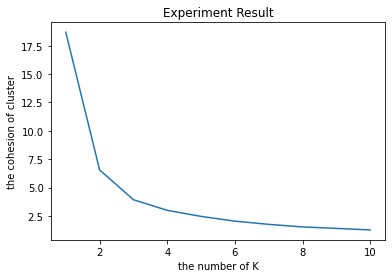

In [ ]:
from matplotlib import pyplot as plt #k값의 변화에 따라 응집도가 어떻게 변하는지 시각화하기 위한 모듈

plt.plot([1,2,3,4,5,6,7,8,9,10], inertia)
plt.xlabel('the number of K')
plt.ylabel('the cohesion of cluster')
plt.title('Experiment Result')
plt.show()       #k값이 4인 경우부터 그래프의 경사가 완만해지는 것을 알 수 있다. 따라서 k값을 4로 설정하기로 함. k값이 너무 커서도 안 됨 (의미 없이 작은 군집으로 나눌 수 있기 때문)


In [ ]:

def unsupervised_learning(data, n=4):
    # cluster 개수 -> km_model.inertia_ 를 보면 기울기 변화가 작아지는 부분이 3
    km_model = km(n_clusters = n, algorithm = 'auto')
    km_model.fit(data)    # 학습
    predict_list = km_model.predict(data)    # clustering
    group_list = [ [] for _ in range(n)]    # 잘 됐는지 확인하려는 list
    for i in range(n):
        group_list[i] = [ init_data[idx] for idx,j in enumerate(predict_list) if j == i]
        # init_data는 ['이건 하나의 글입니다', '이건 다른 글이죠', ...] 같은 초기 data
        # print(i, 'group is', group_list[i][:10])     # 각 cluster 당 10개씩 출력
    return predict_list, group_list



unsupervised_learning(result)  #각 문장이 몇번째 군집에 해당하는지에 대한 리스트 확인할 수 있음 또한 그 문장들을 클러스터 별로 나눈 이중 리스트도 확인 가능

# 2단계 사용자가 궁금한 내용에 대한 문장을 입력 후, 범죄 유형을 분류해줄 classifier 제작

##2-1. 지식인 등 직접 수집한, 각 범죄에 대한 데이터셋을 pandas를 이용하여 불러 옴


In [ ]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import nltk
import random

#defamation_csv='./명예훼손.csv'
#sex_crime='./성범죄.csv'

defamation=pd.read_csv('./명예훼손.csv', names=['text'])
sex_crime=pd.read_csv('./성범죄.csv', names=['text'])
privacy=pd.read_csv('./개인정보.csv', names=['text'])
property_=pd.read_csv('./재산권.csv', names=['text'])

data=([(line['text'], 'defamation') for index, line in defamation.iterrows()]+[(line['text'], 'sex_crime') for index, line in sex_crime.iterrows()]+[(line['text'], 'privacy') for index, line in privacy.iterrows()]+[(line['text'], 'property_') for index, line in property_.iterrows()])
data

[('허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄와 관련한 피해 사례가 증가하고 있지만, 일반적으로, 어떠한 죄명을, 어떻게 주장하여 처벌을 요구하여야 하는지 정확하게 알기 어려운 경우가 많습니다.?',
  'defamation'),
 ('의뢰인은 허위사실을 유포하여, 자신의 명예를 훼손한 피고소인의 잘못된 행동으로 인하여, 극심한 정도의 정신적 고통을 겪었습니다. 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 허위사실에 의한 명예훼손죄 ',
  'defamation'),
 ('허위사실을 유포 허위사실을 유포  허위사실을 유포 허위사실을 유포 허위사실을 유포 허위사실을 유포 허위사실을 유포 피고소인은 계속하여 의뢰인에 관한 허위사실을 유포하고 다녔던바, 의뢰인은 계속해서 허위사실을 유포하는 피고소인에 대한 처벌이 가능한지 알아보고자, 본 버무법인을 방문한 상황이었습니다.  ',
  'defamation'),
 ('의뢰인의 사건은 형법상 명예훼손죄에 해당하여 2년 이하의 징역이나 금고 또는 500만원 이하의 벌금에 처해질 수 있는 사건에 해당합니다. 형법상 명예훼손죄에 형법상 명예훼손죄에 형법상 명예훼손죄에 형법상 명예훼손죄에 형법상 명예훼손죄에 형법상 명예훼손죄에',
  'defamation'),
 ('특히 이 사건은 의뢰인이 피해자가 허위 사실을 유포하고 다닌 것에 대해 해명을 요구하는 과정에서 발생한 것이라 의뢰인은 정말 억울하게 처벌을 받을 우려가 있었습니다. 허위 사실을 유포하고 다닌 것 허위 사실을 유포하고 다닌 것 허위 사실을 유포하고 다닌 것 허위 사실을 유포하고 다닌 것 ',
  'def

## 2-2.Konlpy를 이용하여 각 데이터셋에 대한 tokenize한다

In [ ]:
from konlpy.tag import Mecab

tokens = []
for text in data:
  mecab=Mecab()
  for i in range(len(text)-1):
    tmp=mecab.nouns(text[i])
    for j in tmp:
      tokens.append(j)
tokens=set(tokens)
tokens


{'게시판',
 '소지',
 '증서',
 '법',
 '수사대',
 '인사',
 '폰',
 '과태료',
 '원작자',
 '뱅크',
 '역무',
 '동일',
 '거기',
 '근로자',
 '것',
 '아동',
 '증가',
 '욕설',
 '타인',
 '방조',
 '출시',
 '조사',
 '유무',
 '보상',
 '이메일',
 '운영',
 '당사자',
 '신원',
 '굴',
 '사',
 '주문',
 '개발',
 '내부',
 '욕',
 '소유',
 '만화',
 '기대',
 '필터링',
 '성교',
 '방해',
 '키워드',
 '공표',
 '과실상계',
 '자',
 '이하',
 '외모',
 '요구',
 '종교',
 '고통',
 '날',
 '죄',
 '음란',
 '도입',
 '성매매',
 '기능',
 '사실심',
 '보호법',
 '입장',
 '매출액',
 '수수료',
 '수사',
 '자신',
 '잣',
 '기본법',
 '심원',
 '지칭',
 '캡처',
 '최종',
 '세무서',
 '현장',
 '간',
 '묘사',
 '비디오',
 '업로드',
 '여',
 '등',
 '수탁자',
 '다량',
 '능력',
 '전화',
 '일',
 '결정',
 '기망',
 '저',
 '표현',
 '구성',
 '해',
 '부호',
 '특수',
 '음향',
 '성명',
 '입력',
 '안',
 '용행',
 '부가가치세',
 '여학생',
 '경정',
 '방문',
 '나',
 '부모',
 '단어',
 '접근권',
 '명예훼손',
 '제출',
 '전산망',
 '가중',
 '병신',
 '성폭력',
 '발',
 '징수',
 '일부',
 '부정',
 '앱',
 '미국',
 '유발',
 '모',
 '법정주의',
 '가해자',
 '통지',
 '여지',
 '롤플레잉',
 '가짜',
 '조',
 '동영상',
 '공정거래위',
 '특례',
 '생활',
 '원심',
 '위',
 '카톡',
 '게시물',
 '남',
 '위협',
 '관',
 '운용',
 '업종',
 '비트코인',
 '관련',
 '정도',
 '음악',
 '거

## 2-3. training data에 대한 word embedding 진행

In [ ]:
sentence=[]
label=[]

for text in data:

  sentence.append(text[0])

  if text[1]=='defamation':
    label.append(0)
  if text[1]=='sex_crime':
    label.append(1)
  if text[1]=='privacy':
    label.append(2)  
  if text[1]=='property_':
    label.append(3)

tokenized_sentence=[]

#sentence의 각 문장을 명사 단위로 토큰화
for text in sentence:
  tokenized_sentence.append(mecab.nouns(text))

#word embedding
from gensim.models import Word2Vec as w2v
model = w2v(tokenized_sentence, size=100, window=6, min_count=7, workers=4, iter=7, sg=1)



def get_n_tokens(data, model):   
                            
    result = []                 
                                   
    word_list = ['재산', '개인', '명예훼손','성범죄']


    for i,j in enumerate(data):
        dist = [0] * len(word_list)
        if not data[i]:   # 내용이 없는 글
            pass
        elif len(data[i]) == 1:     # 한 토큰으로 된 글
            for l,m in enumerate(word_list):
                try:
                    dist[l] = model.similarity(m, data[0])
                except:
                    continue
        else:     # 한 토큰 이상으로 된 글
            for idx, k in enumerate(j):
                if idx >= 200:   # 토큰 200개만 사용한다.
                    break
                for l,m in enumerate(word_list):
                    try:
                        dist[l] += model.similarity(m, k)
                    except:
                        continue
        result.append([x/(idx+1) for x in dist])
    return result

x_train=get_n_tokens(tokenized_sentence, model)

x_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).


[[0.4351561322356715,
  0.2593536331798091,
  0.7357142599243106,
  0.2883882838668245],
 [0.4409939219088604,
  0.26927558332681656,
  0.7462088633328676,
  0.29978725500404835],
 [0.2595738185569644,
  0.2018625855445862,
  0.5734521709382534,
  0.34240624606609343],
 [0.5290143298251289,
  0.309405434344496,
  0.7745078255732855,
  0.3158546271068709],
 [0.24475150627474632,
  0.23530632690075906,
  0.5411006673689811,
  0.35332432028747374],
 [0.34691782016307116,
  0.26477015515168506,
  0.5118199388186137,
  0.36166031161944073],
 [0.35190393502199196,
  0.15088331779535813,
  0.6079416901250428,
  0.3787162307697006],
 [0.370536292534928,
  0.16343827604121247,
  0.5562214646921602,
  0.29745466080169347],
 [0.2983347536349783,
  0.1839625342768066,
  0.6074176783464393,
  0.4391107534875675],
 [0.36553324865443365,
  0.18082861965965658,
  0.5418354556674049,
  0.3599218207278422],
 [0.46301420153148715,
  0.2756944712131254,
  0.6205618107511152,
  0.3871976872605662],
 [0.378

##2-4. scikitlearn을 이용한 SGD Classifier 제작 

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(x_train,label)
predicted_Y = sgd_clf.predict(x_train)
for i in range(214):
  print(predicted_Y[i], label[i])
print(sgd_clf.score(x_train, label))

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
2 0
0 0
0 0
3 0
0 0
2 0
0 0
3 0
3 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
2 0
2 0
0 0
0 0
3 0
0 0
0 0
0 0
2 0
0 0
0 0
3 0
0 0
0 0
0 0
0 0
0 0
3 0
0 0
3 0
1 1
1 1
1 1
1 1
1 1
2 1
2 1
1 1
3 1
3 1
1 1
2 1
2 1
1 1
1 1
2 1
2 1
3 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
2 1
1 1
1 1
2 1
2 1
2 1
2 1
1 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
3 1
1 1
1 1
1 1
2 2
2 2
2 2
2 2
3 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
3 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
3 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
3 3
3 3
3 3
3 3
2 3
2 3
2 3
3 3
2 3
3 3
3 3
0 3
3 3
3 3
3 3
2 3
3 3
3 3
2 3
2 3
2 3
3 3
3 3
3 3
2 3
2 3
2 3
3 3
3 3
3 3
0 3
3 3
3 3
2 3
3 3
2 3
3 3
3 3
2 3
3 3
2 3
3 3
3 3
3 3
3 3
2 3
3 3
3 3
3 3
3 3
3 3
3 3
2 3
3 3
3 3
3 3
3 3
0.7102803738317757


## 2-5. 사용자가 궁금한 문장을 입력받고 해당 분류에 대해 반환

In [ ]:
input1=[]

while True:
  q=input("입력하시겠습니까?: (Y/N)")
  if q=="Y" or q=="y":
    a=input("법률 상담하고 싶은 내용을 입력해주세요: ")
    input1.append(a)
  elif q=="n" or q=="N":
    break
  else:
    print("Y(y) 또는 N(n)으로 입력해주세요")

input_token=[]
def tokenize_input(text):
    mecab=Mecab()
    for i in range(len(text)):
      input_token.append(mecab.nouns(text[i]))

tokenize_input(input1)

input_model = w2v(input_token, size=25, window=1, min_count=1, workers=4, iter=7, sg=1)
input_result=get_n_tokens(input_token,input_model)
classified=sgd_clf.predict(input_result)

if classified==0:
  print("정통망법 명예훼손과 관련이 있습니다")
if classified==1:
  print("정통망법 성범죄와 관련이 있습니다")
if classified==2:
  print("정통망법 개인정보과 관련이 있습니다")
if classified==3:
  print("정통망법 재산권과 관련이 있습니다")

입력하시겠습니까?: (Y/N)Y
법률 상담하고 싶은 내용을 입력해주세요: 음악을 인터넷에서 불법으로 다운로드 했습니다.
입력하시겠습니까?: (Y/N)N
정통망법 재산권과 관련이 있습니다


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).


# 3단계 크롤링한 정보통신망 법조항에서 해당하는 범죄 유형에 대한 정보를 반환

## 3-1. 크롤링한 정보통신망 법 조항 불러오기

In [ ]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
from konlpy.tag import Mecab

path='./정보통신망.csv'
df3=pd.read_csv(path)
df4=df3.iloc[:,[0]]
df4=df4.dropna(axis=0)
df4

,제1장 총칙
0,제1조(목적) 이 법은 정보통신망의 이용을 촉진하고 정보통신서비스를 이용하는 자를 ...
1,제2조(정의) ① 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2004. ...
3,② 이 법에서 사용하는 용어의 뜻은 제1항에서 정하는 것 외에는 「국가정보화 기본법...
4,제2조(정의) ① 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2004. ...
6,제3조(정보통신서비스 제공자 및 이용자의 책무) ① 정보통신서비스 제공자는 이용자를...
...,...
194,15. 제56조제1항을 위반하여 약관을 신고하지 아니한 자\n16. 제57조제2항을...
195,제76조(과태료) ① 다음 각 호의 어느 하나에 해당하는 자와 제7호부터 제11호까...
196,7. 제50조제1항부터 제3항까지의 규정을 위반하여 영리 목적의 광고성 정보를 전송...
198,"12의3. 제50조제7항을 위반하여 수신동의, 수신거부 또는 수신동의 철회에 대한 ..."


## 3-2. 법 조항 tokenize

In [ ]:
lawlist=df4.values.tolist()
token=[]

def tokenize_sentence(text):
    mecab=Mecab()
    for i in range(len(text)):
      token.append(mecab.nouns(text[i][0]))

tokenize_sentence(lawlist)
token

[['조',
  '목적',
  '법',
  '정보',
  '통신망',
  '이용',
  '촉진',
  '정보',
  '통신',
  '서비스',
  '이용',
  '자',
  '보호',
  '정보',
  '통신망',
  '이용',
  '수',
  '환경',
  '조성',
  '국민',
  '생활',
  '향상',
  '공공복리',
  '증진',
  '이바지',
  '목적',
  '개정',
  '전문',
  '개정'],
 ['조',
  '정의',
  '법',
  '사용',
  '용어',
  '뜻',
  '다음',
  '개정',
  '정보',
  '통신망',
  '전기',
  '통신',
  '사업',
  '법',
  '조제',
  '호',
  '전기',
  '통신',
  '설비',
  '이용',
  '전기',
  '통신',
  '설비',
  '컴퓨터',
  '컴퓨터',
  '용기',
  '술',
  '활용',
  '정보',
  '수신',
  '정보',
  '통신',
  '체제',
  '말',
  '정보',
  '통신',
  '서비스',
  '란',
  '전기',
  '통신',
  '사업',
  '법',
  '조제',
  '호',
  '전기',
  '통신',
  '역무',
  '이',
  '이용',
  '정보',
  '제공',
  '정보',
  '제공',
  '매개',
  '것',
  '말',
  '정보',
  '통신',
  '서비스',
  '제공',
  '란',
  '전기',
  '통신',
  '사업',
  '법',
  '조제',
  '호',
  '전기',
  '통신',
  '사업자',
  '영리',
  '목적',
  '전기',
  '통신',
  '사업자',
  '기',
  '통신',
  '역무',
  '이용',
  '정보',
  '제공',
  '정보',
  '제공',
  '매개',
  '자',
  '말',
  '이용자',
  '정보',
  '통신',
  '서비스',
  '제공',
  '제공',
  '정보',
  '통신',
  '서비스',
  '이용',
  '자',

## 3-3.  2단계에서 반환한 label(속하는 분류)값에 따라 해당하는 법 조항 print 

In [ ]:
for label in classified:
  if label==0: #입력한 문장이 속하는 분류가 명예훼손  
    key="명예"
    for i in range(len(token)):
      if key in token[i]:
        print(lawlist[i])
  elif label==1: #입력한 문장이 속하는 분류가 성범죄
    key="음란"
    for i in range(len(token)):
      if key in token[i]:
        print(lawlist[i])
  elif label=="sexual_abuse": #입력한 문장이 속하는 분류가 개인정보
    key="개인정보"
    for i in range(len(token)):
      if key in token[i]:
        print(lawlist[i])
  elif label==3: #입력한 문장이 속하는 분류가 재산 
    key="재산"
    for i in range(len(token)):
      if key in token[i]:
        print(lawlist[i])



['제48조의5(정보통신망연결기기등 관련 침해사고의 대응 등) ① 과학기술정보통신부장관은 정보통신망연결기기등과 관련된 침해사고가 발생하면 관계 중앙행정기관의 장과 협력하여 해당 침해사고의 원인을 분석할 수 있다.\n② 과학기술정보통신부장관은 정보통신망연결기기등과 관련된 침해사고가 발생하여 국민의 생명ㆍ신체 또는 재산에 위험을 초 래할 가능성이 있는 경우 관계 중앙행정기관의 장에게 다음 각 호의 조치를 하도록 요청할 수 있다.\n1. 제47조의4제1항에 따른 취약점 점검, 기술 지원 등의 조치\n2. 피해 확산을 방지하기 위하여 필요한 조치\n3. 그 밖에 정보통신망연결기기등의 정보보호를 위한 제도의 개선\n③ 과학기술정보통신부장관은 정보통신망연결기기등과 관련된 침해사고가 발생한 경우 해당 정보통신망연결기기등을 제조하 거나 수입한 자에게 제품 취약점 개선 등 침해사고의 확대 또는 재발을 방지하기 위한 조치를 할 것을 권고할 수 있다.\n④ 과학기술정보통신부장관은 대통령령으로 정하는 전문기관이 다음 각 호의 사업을 수행하는 데 필요한 비용을 지원할 수 있 다.\n1. 정보통신망연결기기등과 관련된 정보보호지침 마련을 위한 연구\n2. 정보통신망연결기기등과 관련된 시험ㆍ검사ㆍ인증 등의 기준 개선 연구 [본조신설 2020. 6. 9.]\n[시행일 : 2020. 12. 10.] 제48조의5']
['2. 통신과금서비스이용자보호계획\n3. 업무를 수행할 수 있는 인력과 물적 설비\n4. 사업계획서\n② 제1항에 따라 등록할 수 있는 자는 「상법」제170조에 따른 회사 또는 「민법」제32조에 따른 법인으로서 자본금ㆍ출자총액 또 는 기본재산이 5억원 이상의 범위에서 대통령령으로 정하는 금액 이상이어야 한다.\n③ 통신과금서비스제공자는 「전기통신사업법」 제22조에도 불구하고 부가통신사업자의 신고를 하지 아니할 수 있다.<개정 2010. 3. 22.>\n④ 「전기통신사업법」 제23조부터 제26조까지의 규정은 통신과금서비스제공자의 등록사항의 변경, 사업의 양도ㆍ양수 또는 합 병ㆍ상속

#번외 SGD 모델 이전에 시도해본 모델들
1. Machine Learning for Kids 모델
2. nltk를 활용한 Naive Bayes 모델
3. Keras를 활용한 인공 신경망 모델 

## 1.Machine Learning for Kids를 활용한 분류기

In [ ]:
import requests

# This function will pass your text to the machine learning model
# and return the top result with the highest confidence
def classify(text):
    key = "2cf69d20-4218-11eb-99d9-45fbfe2aca275bc236e3-9f4e-4f50-a642-bbc55c66b990"
    url = "https://machinelearningforkids.co.uk/api/scratch/"+ key + "/classify"

    response = requests.get(url, params={ "data" : text })

    if response.ok:
        responseData = response.json()
        topMatch = responseData[0]
        return topMatch
    else:
        response.raise_for_status()


# CHANGE THIS to something you want your machine learning model to classify
demo = classify("The text that you want to test")

label = demo["class_name"]
confidence = demo["confidence"]


# CHANGE THIS to do something different with the result
print ("result: '%s' with %d%% confidence" % (label, confidence))
If you know how to use it, your API key for this project is:

SyntaxError: ignored

##2.nltk를 활용한 naive bayes 모델

In [ ]:
# 3. Create training data
train = []
features = {}
for x in data:
  for word in tokens:
    features[word] = (word in mecab.nouns(x[0]))
  train.append((features,x[1]))

train

In [ ]:

random.shuffle(train)
train_x = train[:225]
test_x = train[225:]
# 5. Define classifier - NaiveBayes
nb_classifier = nltk.NaiveBayesClassifier.train(train_x)
# 6. Accuracy
print("NB Accuracy: ", (nltk.classify.accuracy(nb_classifier, test_x)) * 100)
nb_classifier.show_most_informative_features() 


NB Accuracy:  0
Most Informative Features
                       전 = False          defama : privac =      1.0 : 1.0
                      설비 = False          defama : privac =      1.0 : 1.0
                    다중접속 = False          defama : privac =      1.0 : 1.0
                      성기 = False          defama : privac =      1.0 : 1.0
                       발 = False          defama : privac =      1.0 : 1.0
                      수회 = False          defama : privac =      1.0 : 1.0
                      단기 = False          defama : privac =      1.0 : 1.0
                      기계 = False          defama : privac =      1.0 : 1.0
                     이미지 = False          defama : privac =      1.0 : 1.0
                      일탈 = False          defama : privac =      1.0 : 1.0


## 3.Keras를 활용한 인공 신경망 모델

In [ ]:
import pandas as pd
from pandas import Series,DataFrame
from konlpy.tag import Mecab

defamation=pd.read_csv('./명예훼손.csv', names=['text'])
sex_crime=pd.read_csv('./성범죄.csv', names=['text'])
privacy=pd.read_csv('./개인정보.csv', names=['text'])
property_=pd.read_csv('./재산권.csv', names=['text'])
unknown=pd.read_csv('./non.csv', names=['text'])

defamation=defamation.dropna(axis=0)
sex_crime=sex_crime.dropna(axis=0)
privacy=privacy.dropna(axis=0)
property_=property_.dropna(axis=0)

data=([(line['text'], 'defamation') for index, line in defamation.iterrows()]
      +[(line['text'], 'sex_crime') for index, line in sex_crime.iterrows()]
      +[(line['text'], 'privacy') for index, line in privacy.iterrows()]
      +[(line['text'], 'property_') for index, line in property_.iterrows()]
      +[(line['text'], 'unknown') for index, line in unknown.iterrows()])

In [ ]:
import random

random.shuffle(data)
train_set=data[:238]
test_set=data[238:]

train_data=[]
train_label=[]
test_data=[]
test_label=[]

#data,label 분리하기
for text in train_set:
  train_data.append(text[0])

  if text[1]=='defamation':
    train_label.append(0)
  if text[1]=='sex_crime':
    train_label.append(1)
  if text[1]=='privacy':
    train_label.append(2)  
  if text[1]=='property_':
    train_label.append(3)
  if text[1]=='unknown':
    train_label.append(4)

for text in test_set:
  test_data.append(text[0])

  if text[1]=='defamation':
    test_label.append(0)
  if text[1]=='sex_crime':
    test_label.append(1)
  if text[1]=='privacy':
    test_label.append(2)  
  if text[1]=='property_':
    test_label.append(3)
  if text[1]=='unknown':
    test_label.append(4)

In [ ]:
from keras.preprocessing.text import Tokenizer

# 가장 빈도가 높은 50개의 단어만 선택하도록 Tokenizer 객체를 만듭니다.
train_tokenizer=Tokenizer(num_words=50)
test_tokenizer=Tokenizer(num_words=50)

# 단어 인덱스를 구축합니다.
train_tokenizer.fit_on_texts(train_data)
test_tokenizer.fit_on_texts(test_data)

# 문자열을 정수 인덱스의 리스트로 변환합니다.
train_sequences=train_tokenizer.texts_to_sequences(train_data)
test_sequences=test_tokenizer.texts_to_sequences(test_data)

# 직접 원-핫 이진 벡터 표현을 얻을 수 있습니다.
# 원-핫 인코딩 외에 다른 벡터화 방법들도 제공합니다!
train_one_hot_results = train_tokenizer.texts_to_matrix(train_data, mode='binary')
test_one_hot_results = test_tokenizer.texts_to_matrix(test_data, mode='binary')

#계산된 단어 인덱스를 구합니다.
train_word_index=train_tokenizer.word_index
test_word_index=test_tokenizer.word_index
print("Found %s unique token." %len(train_word_index)) 
print("Found %s unique token." %len(test_word_index))

Found 3739 unique token.
Found 595 unique token.


In [ ]:
import numpy as np

# 단어를 크기가 1,000인 벡터로 저장합니다.
# 1,000개(또는 그이상)의 단어가 있다면 해싱 충돌이 늘어나고 인코딩의 정확도가 감소될 것입니다
def vectorize_sequences(sequences, dimensionality=1000):
  results = np.zeros((len(sequences), dimensionality))
  for i, sequence in enumerate(sequences):
      results[i, sequence] = 1.
  return results

x_train = vectorize_sequences(train_sequences) # 훈련 데이터 벡터 변환
x_test = vectorize_sequences(test_sequences) #테스트 데이터 벡터 변환

In [ ]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_label) # 훈련 레이블 벡터 변환
one_hot_test_labels = to_categorical(test_label) # 테스트 레이블 벡터 변환

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

x_val = np.array(x_train[:214])
partial_x_train =np.array(x_train[214:])

y_val = np.array(one_hot_train_labels[:214])
partial_y_train = np.array(one_hot_train_labels[214:])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(x_val, y_val))

Epoch 1/20
1/1 [==============================] - 1s 759ms/step - loss: 1.5825 - accuracy: 0.3750 - val_loss: 1.6005 - val_accuracy: 0.1916
Epoch 2/20
1/1 [==============================] - 0s 55ms/step - loss: 1.5644 - accuracy: 0.3333 - val_loss: 1.5989 - val_accuracy: 0.1729
Epoch 3/20
1/1 [==============================] - 0s 56ms/step - loss: 1.5500 - accuracy: 0.3333 - val_loss: 1.5979 - val_accuracy: 0.1729
Epoch 4/20
1/1 [==============================] - 0s 59ms/step - loss: 1.5363 - accuracy: 0.3333 - val_loss: 1.5968 - val_accuracy: 0.1729
Epoch 5/20
1/1 [==============================] - 0s 56ms/step - loss: 1.5228 - accuracy: 0.3333 - val_loss: 1.5956 - val_accuracy: 0.1729
Epoch 6/20
1/1 [==============================] - 0s 51ms/step - loss: 1.5103 - accuracy: 0.3333 - val_loss: 1.5948 - val_accuracy: 0.1682
Epoch 7/20
1/1 [==============================] - 0s 48ms/step - loss: 1.4989 - accuracy: 0.3333 - val_loss: 1.5937 - val_accuracy: 0.1682
Epoch 8/20
1/1 [==========

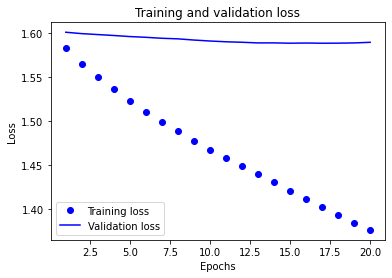

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

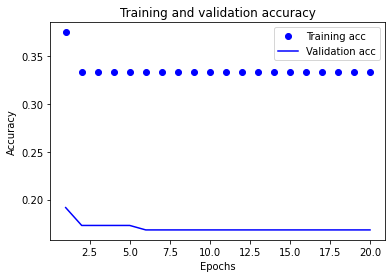

In [ ]:
plt.clf() #그래프를 초기화합니다.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=4,
          batch_size=32,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/4
1/1 [==============================] - 1s 961ms/step - loss: 1.6039 - accuracy: 0.1667 - val_loss: 1.6096 - val_accuracy: 0.1449
Epoch 2/4
1/1 [==============================] - 0s 57ms/step - loss: 1.5817 - accuracy: 0.2917 - val_loss: 1.6092 - val_accuracy: 0.1495
Epoch 3/4
1/1 [==============================] - 0s 67ms/step - loss: 1.5659 - accuracy: 0.3750 - val_loss: 1.6088 - val_accuracy: 0.1495
Epoch 4/4
1/1 [==============================] - 0s 21ms/step - loss: 1.6061 - accuracy: 0.2308


In [ ]:
print("Accuracy of the model:", (results[1]*100), "%")

Accuracy of the model: 23.076923191547394 %
